# Описание: Анализ данных о продажах игр 

Цель проекта: выявить определяющие успешность игры закономерности, что позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

### Часть 1. Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd 
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
 
import warnings
warnings.filterwarnings('ignore')



In [2]:
data_games = pd.read_csv ('/datasets/games.csv')
 
print (data_games.info ())

print (data_games.head (20))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
None
                                            Name Platform  Year_of_Release  \
0                                     Wii Sports      Wii           2006.0   
1                              Super Mario Bros.      NES           1985.0   
2 

In [3]:
data_games.duplicated().sum ()

0

Выводы: 
- пропуски в оценке критиков, пользователей и рейтинге
- разный регистр букв в названиях столбцов, что мешает чтению
- год имеет тип данных float, оценка пользователя имеет тип данных object 

### Часть 2. Подготовка данных
- Замените названия столбцов (приведите к нижнему регистру);
- Преобразуйте данные в нужные типы. Опишите, в каких столбцах заменили тип данных и почему;
- Обработайте пропуски при необходимости:
    -Объясните, почему заполнили пропуски определённым образом или почему не стали это делать;
    -Опишите причины, которые могли привести к пропускам;
- Обратите внимание на аббревиатуру 'tbd' в столбце с оценкой пользователей. Отдельно разберите это значение и опишите, как его обработать;
- Посчитайте суммарные продажи во всех регионах и запишите их в отдельный столбец.

In [4]:
data_games.columns = map(str.lower, data_games.columns) #замена названия столбцов (приводим к нижнему регистру)

print (data_games.head (20)) #строка использовалась для проверки результата

                                            name platform  year_of_release  \
0                                     Wii Sports      Wii           2006.0   
1                              Super Mario Bros.      NES           1985.0   
2                                 Mario Kart Wii      Wii           2008.0   
3                              Wii Sports Resort      Wii           2009.0   
4                       Pokemon Red/Pokemon Blue       GB           1996.0   
5                                         Tetris       GB           1989.0   
6                          New Super Mario Bros.       DS           2006.0   
7                                       Wii Play      Wii           2006.0   
8                      New Super Mario Bros. Wii      Wii           2009.0   
9                                      Duck Hunt      NES           1984.0   
10                                    Nintendogs       DS           2005.0   
11                                 Mario Kart DS       DS       

In [5]:
# Преобразуйте данные в нужные типы. Опишите, в каких столбцах заменили тип данных и почему. 

data_games ['year_of_release'].describe () #изучаем данные в столбце 
#заменяем строки с пробелами на Nan
data_games= data_games.replace(r'^\s*$', np.nan, regex=True)
# удаляем строки с пустыми значениями в столбцах
data_games.dropna(subset = ['name', 'year_of_release', 'genre'], inplace = True)

data_games ['year_of_release'] = data_games ['year_of_release'].astype('int')  #меняем на целые числа, так как год может быть только целым числом

#data_games.info ()


In [6]:
#меняем на числа, нам это будет необходимо для заполнения пропусков, ну и в целом рейтинг - это дробные числа.

data_games['user_score'].unique() 
data_games.loc[data_games['user_score'] == 'tbd', 'user_score'] = ('Nan') #неизвестные данные tbd заменяем на Nan 
data_games['user_score'] = data_games['user_score'].astype('float') #тип object меняем на float 

data_games['user_score'].describe ()
print (data_games ['user_score'].head (20))

0     8.0
1     NaN
2     8.3
3     8.0
4     NaN
5     NaN
6     8.5
7     6.6
8     8.4
9     NaN
10    NaN
11    8.6
12    NaN
13    7.7
14    6.3
15    7.4
16    8.2
17    9.0
18    NaN
19    7.9
Name: user_score, dtype: float64


In [7]:
data_games['rating'] = data_games['rating'].fillna("unknown")
print (data_games.head (10))

                        name platform  year_of_release         genre  \
0                 Wii Sports      Wii             2006        Sports   
1          Super Mario Bros.      NES             1985      Platform   
2             Mario Kart Wii      Wii             2008        Racing   
3          Wii Sports Resort      Wii             2009        Sports   
4   Pokemon Red/Pokemon Blue       GB             1996  Role-Playing   
5                     Tetris       GB             1989        Puzzle   
6      New Super Mario Bros.       DS             2006      Platform   
7                   Wii Play      Wii             2006          Misc   
8  New Super Mario Bros. Wii      Wii             2009      Platform   
9                  Duck Hunt      NES             1984       Shooter   

   na_sales  eu_sales  jp_sales  other_sales  critic_score  user_score  \
0     41.36     28.96      3.77         8.45          76.0         8.0   
1     29.08      3.58      6.81         0.77           NaN 

In [8]:
#добаляем столбец с суммарными продажами

data_games ['sales_sum']= data_games[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)
print (data_games.head (5))



                       name platform  year_of_release         genre  na_sales  \
0                Wii Sports      Wii             2006        Sports     41.36   
1         Super Mario Bros.      NES             1985      Platform     29.08   
2            Mario Kart Wii      Wii             2008        Racing     15.68   
3         Wii Sports Resort      Wii             2009        Sports     15.61   
4  Pokemon Red/Pokemon Blue       GB             1996  Role-Playing     11.27   

   eu_sales  jp_sales  other_sales  critic_score  user_score   rating  \
0     28.96      3.77         8.45          76.0         8.0        E   
1      3.58      6.81         0.77           NaN         NaN  unknown   
2     12.76      3.79         3.29          82.0         8.3        E   
3     10.93      3.28         2.95          80.0         8.0        E   
4      8.89     10.22         1.00           NaN         NaN  unknown   

   sales_sum  
0      82.54  
1      40.24  
2      35.52  
3      32.77  

Мы не можем заполнить оценки, поскольку вряд ли эта величина коррелирует с чем-то еще. То же касается и рейтинга. 
Пропуски могут быть связаны с тем, что каким-то играм просто не было оценок, например, в силу года выхода. 

### Часть 3. Исследовательский анализ данных

1) Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?
2) Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?
3) Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.
4) Не учитывайте в работе данные за предыдущие годы.
5) Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.
6) Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.
7) Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.
8) Соотнесите выводы с продажами игр на других платформах.
9) Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

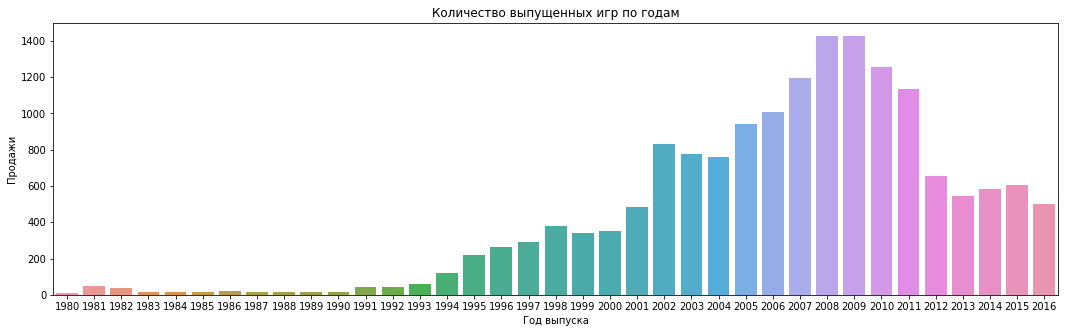

In [9]:
#Посмотрим, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?
plt.figure(figsize=(18, 5))
sns.countplot(data = data_games, x='year_of_release')
plt.title('Количество выпущенных игр по годам')
plt.xlabel("Год выпуска")
plt.ylabel("Продажи")
plt.show()


Большинство игр было выпущено с 2005 по 2015 год. Однако для исследования нам больше подойдут данный с 2014 по 2016 год, поскольку это ближе к прогнозной дате, а индустрия игр быстро меняется. 

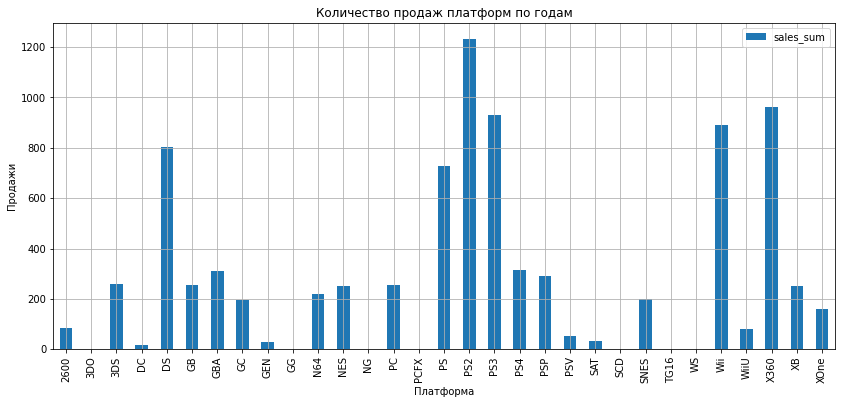

In [10]:
#Построим распределение по годам по платформам с наибольшими суммарными продажами. 

games_platform = data_games.pivot_table(index = 'platform', values = 'sales_sum', aggfunc='sum')
games_platform.plot.bar(style='o-', figsize=(14,6), grid=True)
plt.title('Количество продаж платформ по годам')
plt.xlabel("Платформа")
plt.ylabel("Продажи")
plt.show()


Наиболе популярные платформы : DS, PS2, PS3, Wii, X360

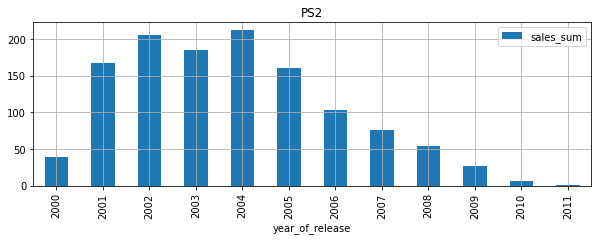

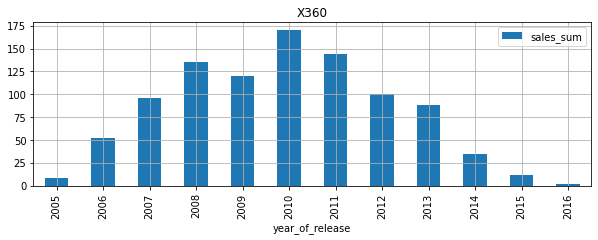

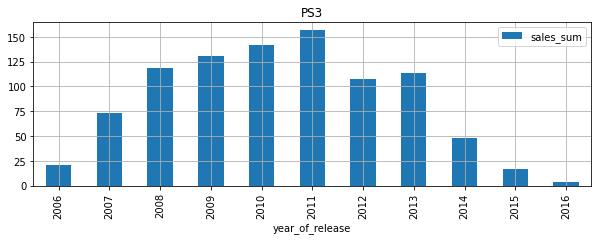

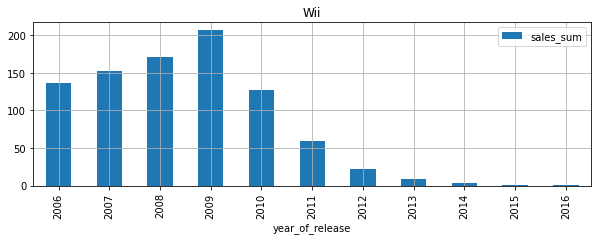

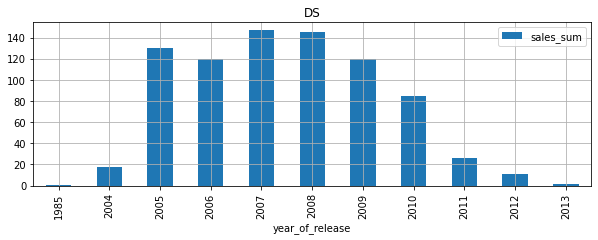

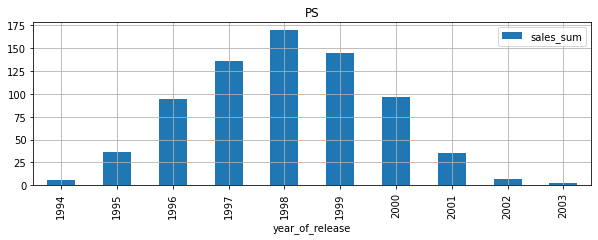

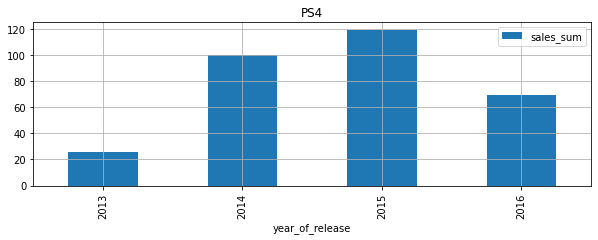

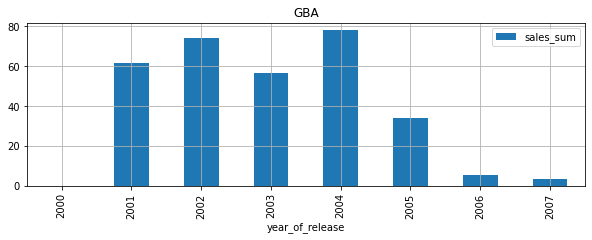

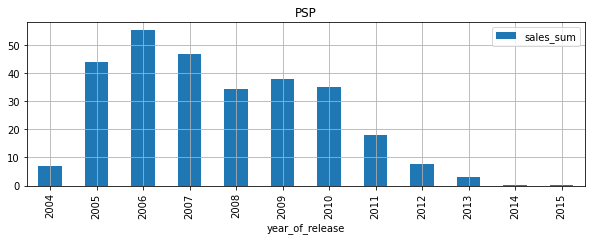

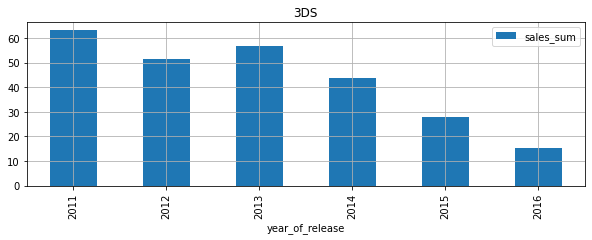

In [11]:
#Посмотрите, как менялись продажи по платформам.
#Определим, за какой характерный срок появляются новые и исчезают старые платформы. 

platforms_top = data_games.pivot_table(index='platform', values='sales_sum', aggfunc='sum')
platforms_top.columns=['sum']
platforms_top = platforms_top.sort_values('sum', ascending = False).head(10)
platforms_top = platforms_top.reset_index()
for i in platforms_top['platform']:
    data_games.query('platform ==@i').pivot_table(index='year_of_release', values='sales_sum', aggfunc='sum').plot(kind='bar', grid=True, figsize=(10, 3))
    plt.title(i)

Судя по графикам, новые платформы живут 7-10 лет и менее. При этом пик плопулярности приходится на середину пути. А вот стартуют все по-разному. У некоторых платформ старт сразу с высоких продаж, а у некоторых с низких и потом растут. 
Некоторые популярные платформы PSP, GBA, PS, Wi6, PS2 - потреяли продажи к периоду исследования. 

In [12]:
#Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.


data_games_query = data_games.query('year_of_release >= 2014')
print (data_games_query.head (10))


                                          name platform  year_of_release  \
31                   Call of Duty: Black Ops 3      PS4             2015   
42                          Grand Theft Auto V      PS4             2014   
47   Pokemon Omega Ruby/Pokemon Alpha Sapphire      3DS             2014   
77                                     FIFA 16      PS4             2015   
87                Star Wars Battlefront (2015)      PS4             2015   
92              Call of Duty: Advanced Warfare      PS4             2014   
94                                     FIFA 17      PS4             2016   
96         Super Smash Bros. for Wii U and 3DS      3DS             2014   
99                   Call of Duty: Black Ops 3     XOne             2015   
105                                  Fallout 4      PS4             2015   

            genre  na_sales  eu_sales  jp_sales  other_sales  critic_score  \
31        Shooter      6.03      5.86      0.36         2.38           NaN   
42     

Актуальный приод - с 2014 года, за 3 года до периода, на который нам надо стоить прогноз. 

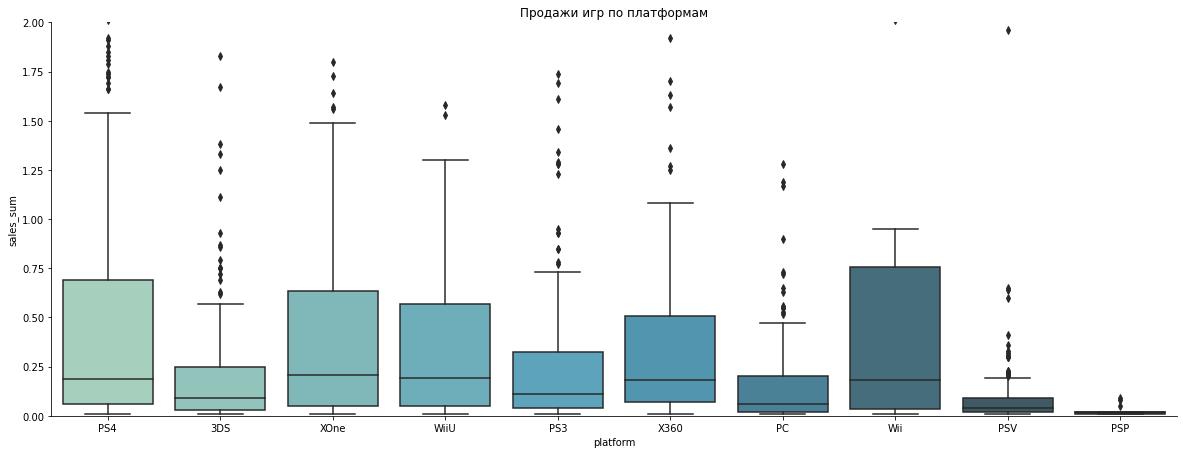

In [13]:
#Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.
#Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат

data_games_query.pivot_table(index='platform', values='sales_sum', aggfunc='sum').nlargest(10, 'sales_sum')

sns.catplot(x="platform", 
            y='sales_sum', 
            kind="box", 
            data= data_games_query, 
            orient='v', 
            height=6, 
            aspect=2.7, 
            palette='GnBu_d')
plt.title('Продажи игр по платформам')
_ = plt.ylim(0, 2)



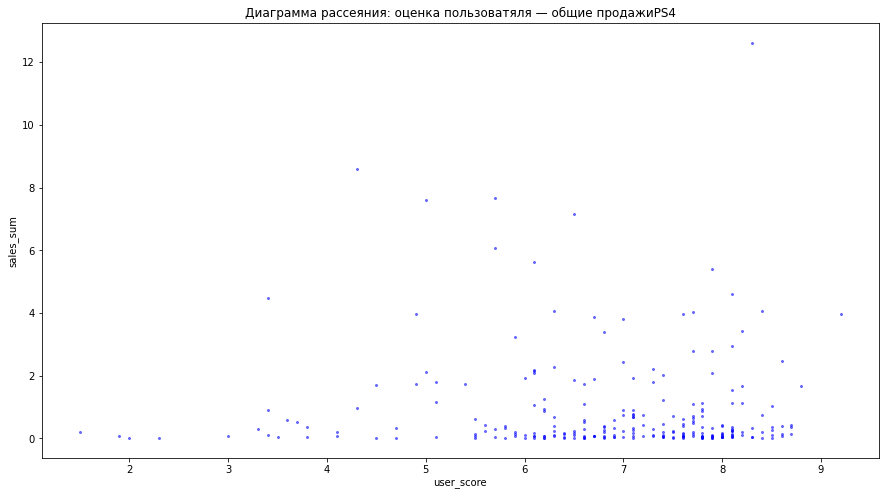

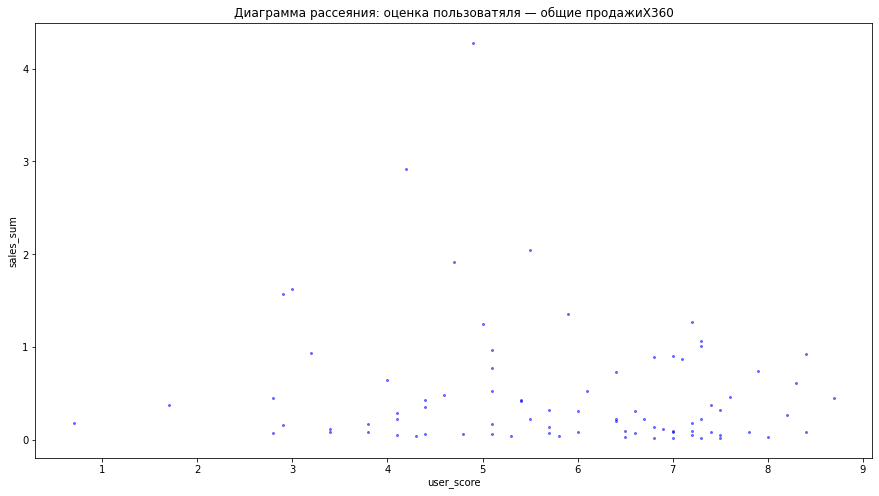

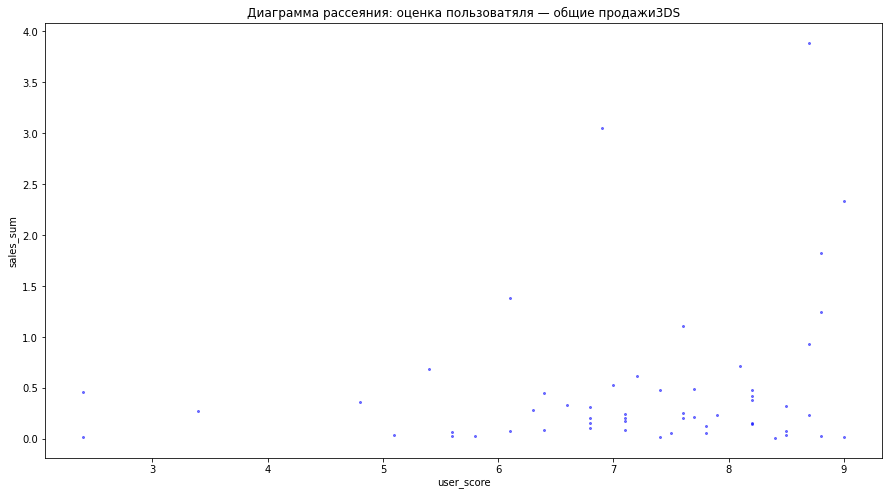

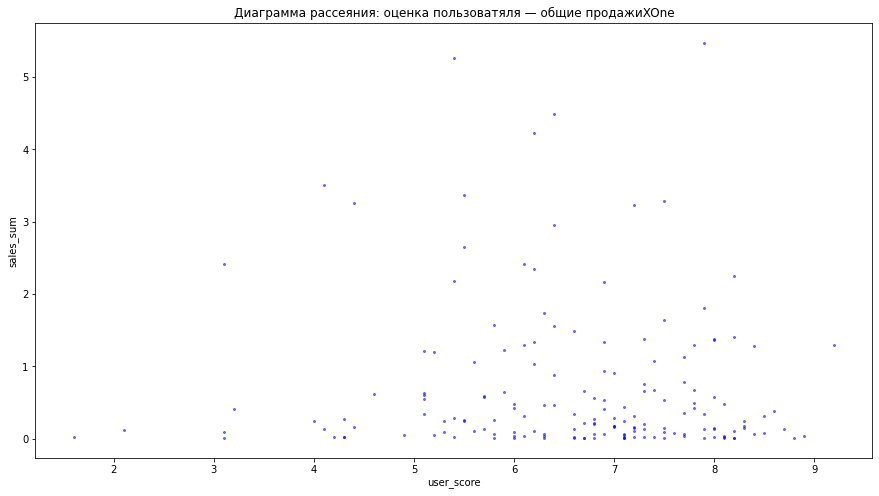

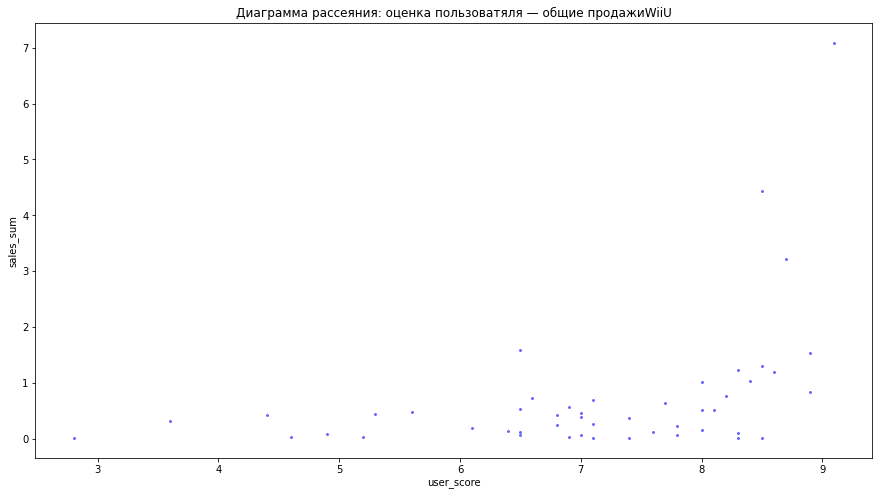

In [14]:
#посмотрим зависимость продаж от оценки пользователей

actual_platform = ['PS4', 'X360', '3DS', 'XOne', 'WiiU']
for name_platform in actual_platform:
    platform_data = data_games_query.query('platform == @name_platform')
    platform_data.plot(kind='scatter', y='sales_sum' , x='user_score', alpha=0.5, subplots=True, figsize=(15,8), c = 'b', s = 4)
    plt.title('Диаграмма рассеяния: оценка пользоватяля — общие продажи'+ name_platform)
 

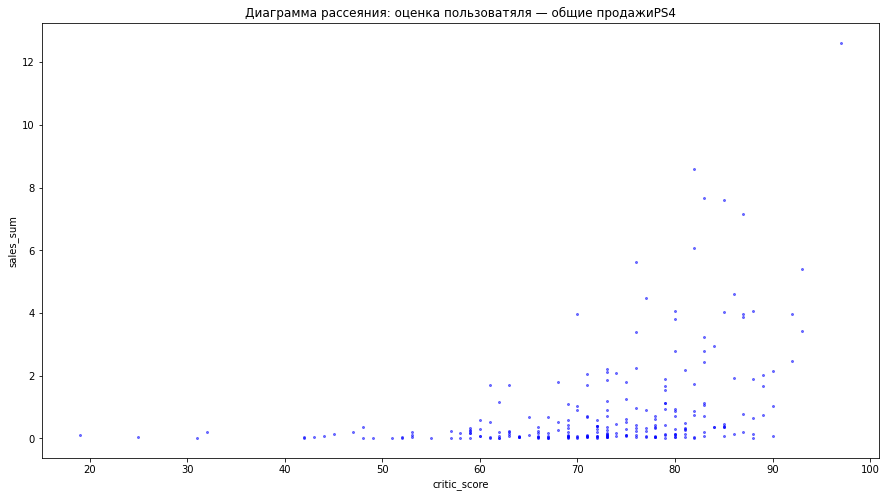

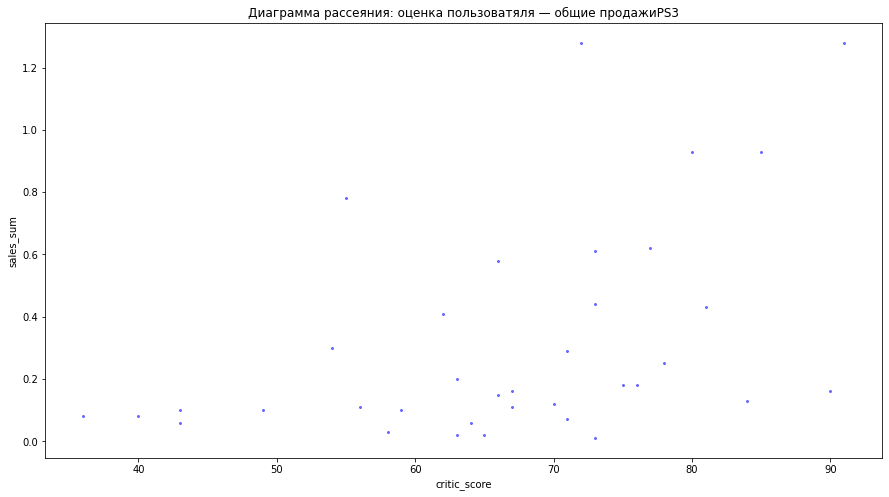

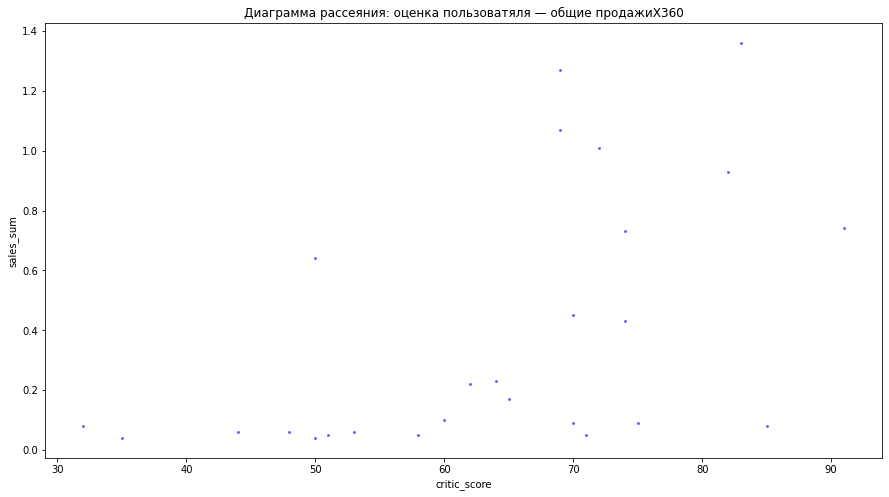

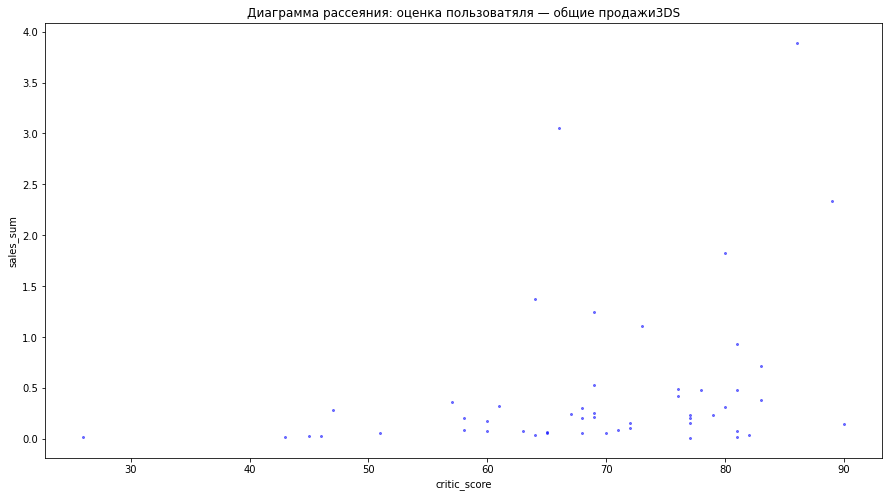

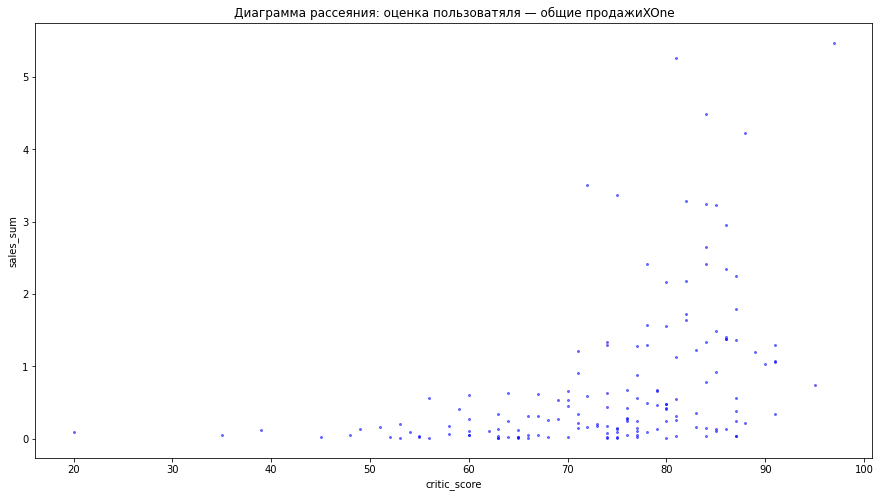

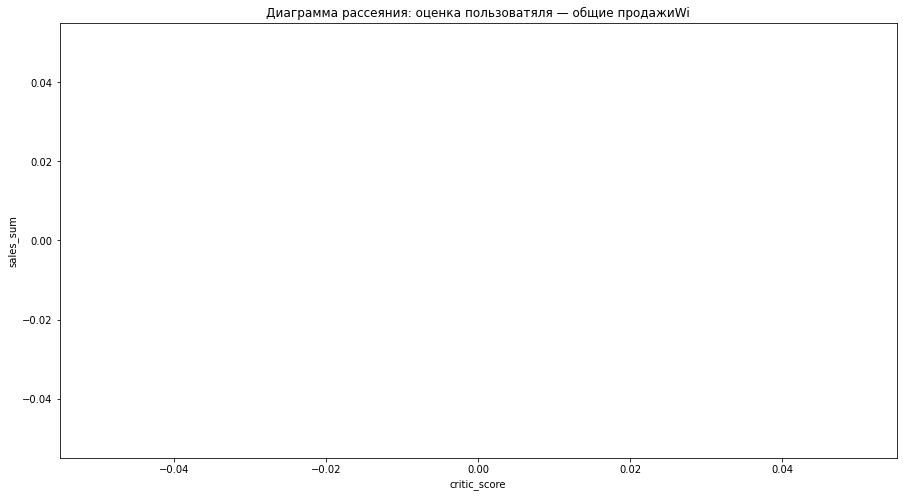

In [15]:
#посмотрим зависимость продаж от оценки критиков

actual_platform = ['PS4', 'PS3', 'X360', '3DS', 'XOne', 'Wi']
for name_platform in actual_platform:
    platform_data = data_games_query.query('platform == @name_platform')
    platform_data.plot(kind='scatter', y='sales_sum' , x='critic_score', alpha=0.5, subplots=True, figsize=(15,8), c = 'b', s = 4)
    plt.title('Диаграмма рассеяния: оценка пользоватяля — общие продажи'+ name_platform)

Как ни странно, оценки пользователей не влияют на продажи, при этом оценки критиков имеют среднее влияни, то есть при повышенеии оценки есть рост продаж, однако нельзя назвать этот рост взрывным. Тенденция верна для всех платформ. 

In [16]:
#Посмотрите на общее распределение игр по жанрам. 

genre_sales = data_games_query.pivot_table(
    index='genre', values='sales_sum', aggfunc= 'median').sort_values(by='sales_sum', ascending=False)
genre_sales = genre_sales.reset_index().rename_axis(None, axis=1)
print (genre_sales)

           genre  sales_sum
0        Shooter      0.515
1         Sports      0.180
2       Platform      0.140
3       Fighting      0.125
4   Role-Playing      0.110
5     Simulation      0.100
6         Action      0.090
7           Misc      0.090
8         Racing      0.090
9       Strategy      0.060
10        Puzzle      0.045
11     Adventure      0.030


Согласно распределению по жанрам, самый продаваемы - шутеры, количество продаж примерно в два раза больше, чем у ближайших конкурентов - спортивных, самые не популярные - паззлы и приключения. 

### Часть 4. Портрет пользователя каждого региона
Определите для пользователя каждого региона (NA, EU, JP):
1) Самые популярные платформы (топ-5). Опишите различия в долях продаж.
2) Самые популярные жанры (топ-5). Поясните разницу.
3) Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [17]:
# Самые популярные платформы (топ-5). Опишите различия в долях продаж.

na_sales = data_games_query.pivot_table(index='platform', values='na_sales', aggfunc='sum').nlargest(5, 'na_sales')
na_sales.columns = ['sales_sum']

eu_sales = data_games_query.pivot_table(index='platform', values='eu_sales', aggfunc='sum').nlargest(5, 'eu_sales')
eu_sales.columns = ['sales_sum']

jp_sales = data_games_query.pivot_table(index='platform', values='jp_sales', aggfunc='sum').nlargest(5, 'jp_sales')
jp_sales.columns = ['sales_sum']


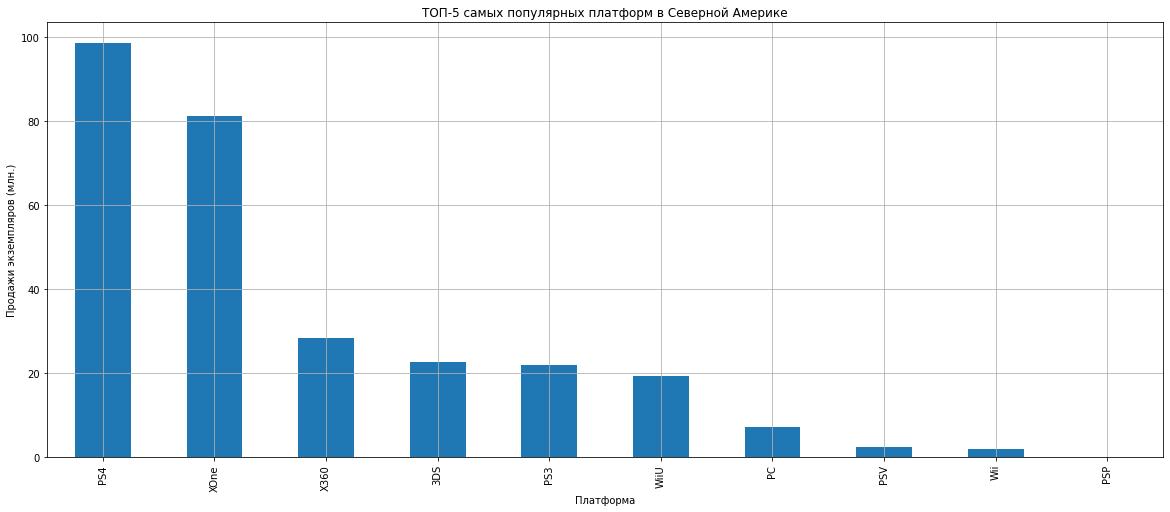

In [19]:
#Узнаем популярность платформ

# ТОП-5 самых популярных платформ в Северной Америке

top_platform_na= data_games_query.groupby('platform')['na_sales'].sum().sort_values(ascending=False)
top_platform_na.plot(x = 'platform', y = 'na_sales', kind = 'bar', figsize=(20,8), grid=True, title = 'ТОП-5 самых популярных платформ в Северной Америке')
plt.xlabel('Платформа')
plt.ylabel('Продажи экземпляров (млн.)')
plt.show()


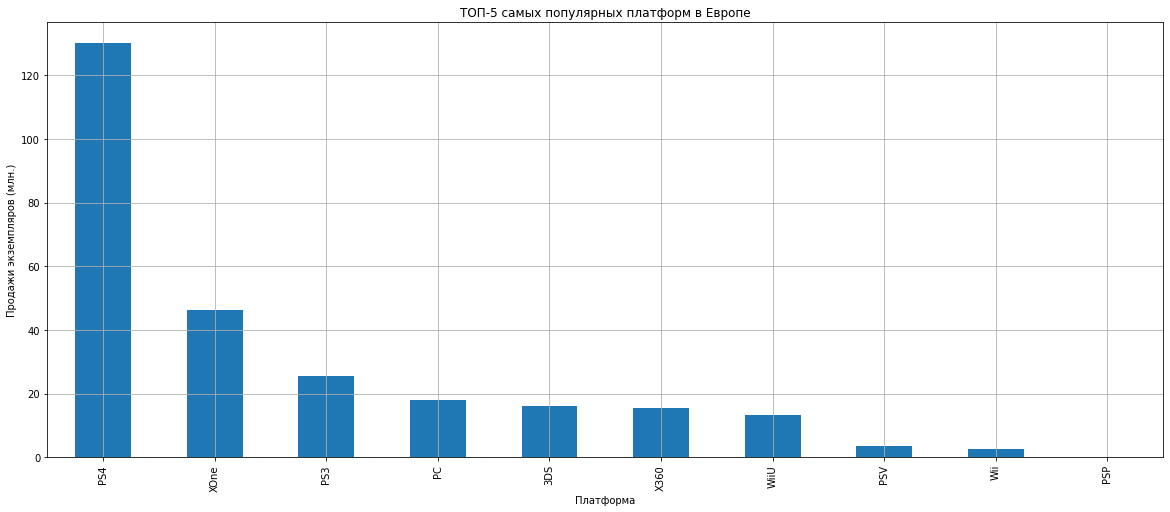

In [20]:
# ТОП-5 самых популярных платформ в Европе

top_platform_na= data_games_query.groupby('platform')['eu_sales'].sum().sort_values(ascending=False)
top_platform_na.plot(x = 'platform', y = 'eu_sales', kind = 'bar', figsize=(20,8), grid=True, title = 'ТОП-5 самых популярных платформ в Европе')
plt.xlabel('Платформа')
plt.ylabel('Продажи экземпляров (млн.)')
plt.show()

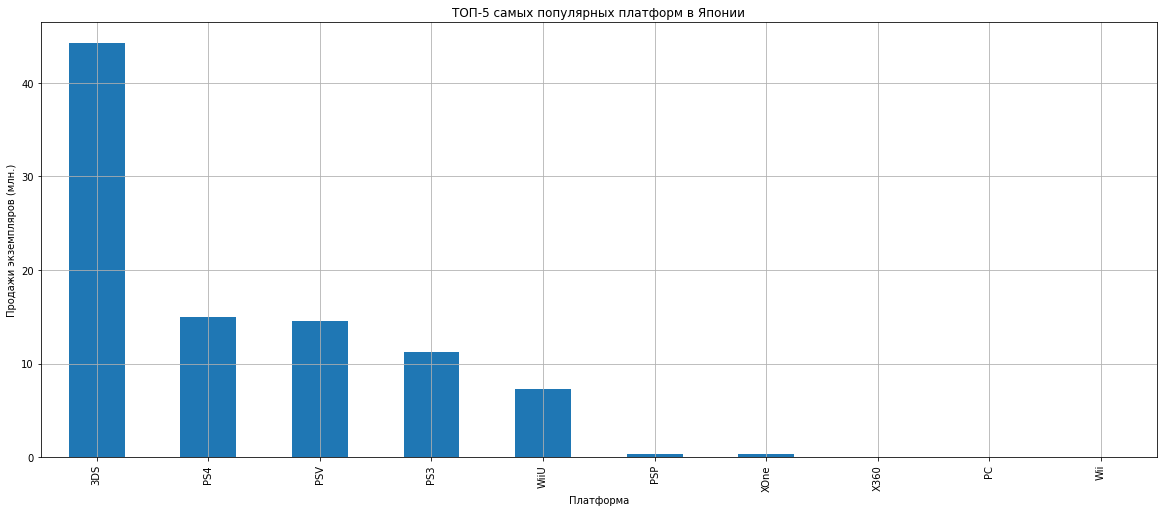

In [21]:
# ТОП-5 самых популярных платформ в Японии

top_platform_na= data_games_query.groupby('platform')['jp_sales'].sum().sort_values(ascending=False)
top_platform_na.plot(x = 'platform', y = 'jp_sales', kind = 'bar', figsize=(20,8), grid=True, title = 'ТОП-5 самых популярных платформ в Японии')
plt.xlabel('Платформа')
plt.ylabel('Продажи экземпляров (млн.)')
plt.show()

Выводы: 
    1. ТОП-5 самых популярных платформ в Северной Америке: X360, PS2, WII, PS3, DS. 
    2. ТОП-5 самых пополярных платформ в Европе: PS2, PS3, X360, WII, PS.
    3. ТОП-5 самых популярных платформ в Японии: DS, PS, PS2, SNES, 3DS. 
        
В целом самые популярные платформы - во всем мире остаются самыми популярными. Есть небольшие отличиня, например в Японии, в отличие от Северной Америки и Европы, популярна SNES, а в Европе не встречается DS. 

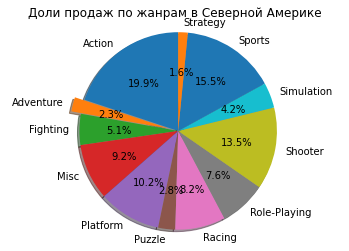

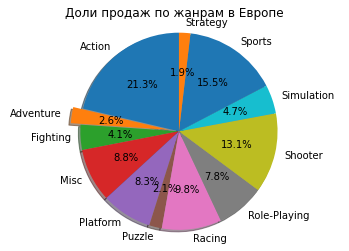

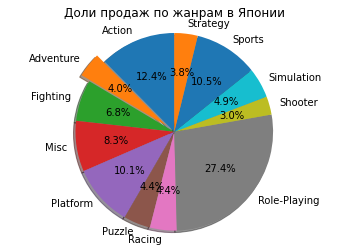

In [22]:
#Узнаем популярность жанров

data_portraits = data_games.groupby('genre')['na_sales', 'eu_sales', 'jp_sales'].sum ()

labels = list(data_portraits.index)
sizes = data_portraits['na_sales']
explode = (0, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)  
 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Доли продаж по жанрам в Северной Америке')
 
plt.show()

data_portraits = data_games.groupby('genre')['na_sales', 'eu_sales', 'jp_sales'].sum ()

labels = list(data_portraits.index)
sizes = data_portraits['eu_sales']
explode = (0, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)  
 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Доли продаж по жанрам в Европе')
plt.show()


data_portraits = data_games.groupby('genre')['na_sales', 'eu_sales', 'jp_sales'].sum ()

labels = list(data_portraits.index)
sizes = data_portraits['jp_sales']
explode = (0, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)  
 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  
plt.title('Доли продаж по жанрам в Японии')
plt.show()

Выводы: 
    1. Самые популярные жанры в Северной Америке: Action, Sports, Shooter, Platform, Misc.
    2. Самые популярные жанры в Европе: Action, Sports, Shooter, Racing, Strategy. 
    3. Самые популярные жанры в Японии: Role-Playing, Action, Sports, Platform, Misc. 
        
Видим, что самая большая доля Северной Америке и Европе не совпадает с самым популярным жанром в Японии. Скорее всего, здесь имеет место различия в менталитете.


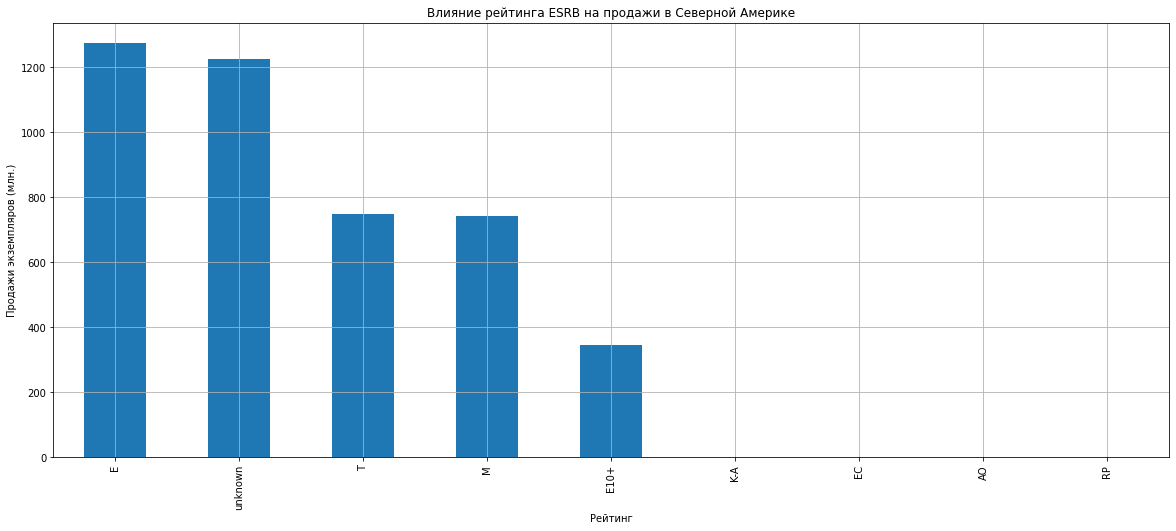

In [23]:
#Изучаем, влияет ли рейтинг ESRB на продажи в отдельном регионе
rating_na = data_games.groupby('rating')['na_sales'].sum().sort_values(ascending=False)
rating_na.plot(x = 'rating', y = 'na_sales', kind = 'bar', figsize=(20,8), grid=True, title = 'Влияние рейтинга ESRB на продажи в Северной Америке')
plt.xlabel('Рейтинг')
plt.ylabel('Продажи экземпляров (млн.)')
plt.show()


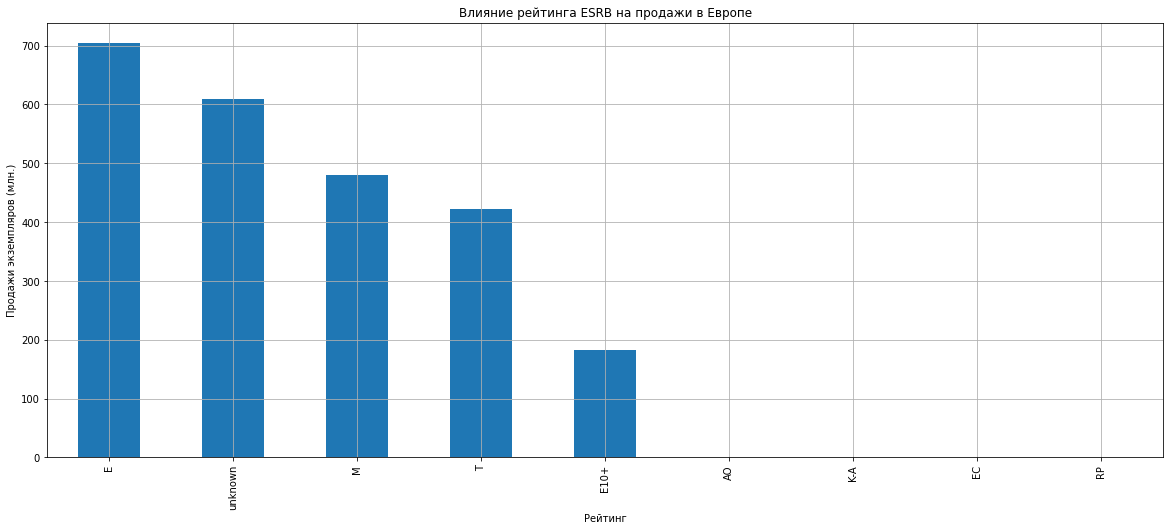

In [24]:
rating_na = data_games.groupby('rating')['eu_sales'].sum().sort_values(ascending=False)
rating_na.plot(x = 'rating', y = 'eu_sales', kind = 'bar', figsize=(20,8), grid=True, title = 'Влияние рейтинга ESRB на продажи в Европе')
plt.xlabel('Рейтинг')
plt.ylabel('Продажи экземпляров (млн.)')
plt.show()

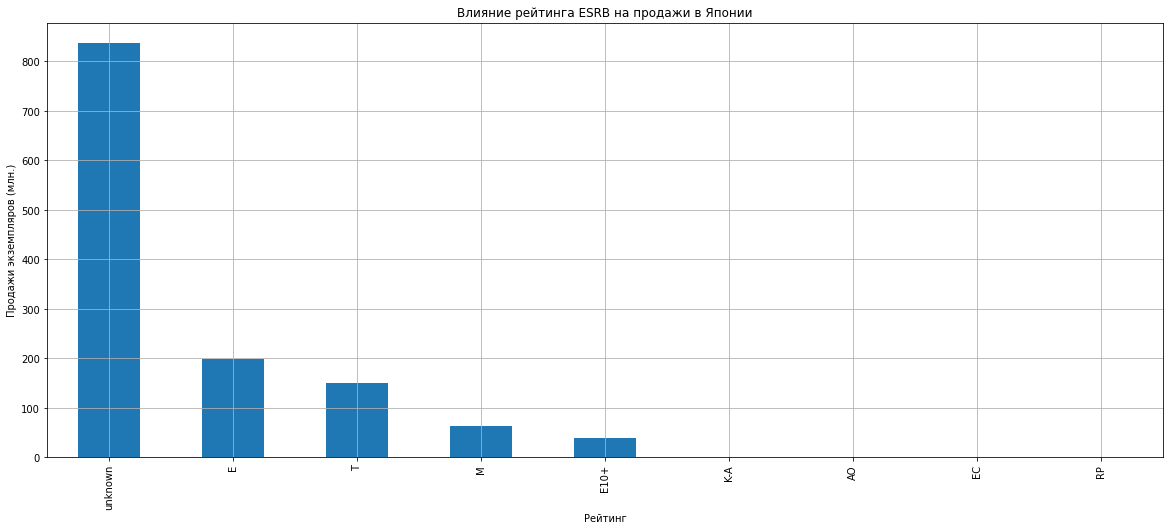

In [25]:
rating_na = data_games.groupby('rating')['jp_sales'].sum().sort_values(ascending=False)
rating_na.plot(x = 'rating', y = 'jp_sales', kind = 'bar', figsize=(20,8), grid=True, title = 'Влияние рейтинга ESRB на продажи в Японии')
plt.xlabel('Рейтинг')
plt.ylabel('Продажи экземпляров (млн.)')
plt.show()

Вывод: к сожалению, самое большое количество платформ с неизвестным рейтингом, во всех странах колиество продаж игр с рейтнгом E - выше. Далее - T и M в Японии и Северной Америке, и M и T - в Европе. Это означает, что самое большое количество продаж у игр с возарастными ограничениями 6+. Но это можно объяснить не столько популярностью детских игр, сколько тем, что это увеличивает выборку. 

### Часть 5. Проверка гипотез
1) Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
2) Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.
3) Задайте самостоятельно пороговое значение alpha.

Нулевая гипотеза - средний пользовательский рейтинг платформы Xbox One равен среднему пользовательскому рейтингу платформы PC. 
Альтернативная гипотеза - средний пользовательский рейтинг платформы Xbox One больше или меньше среднего пользовательского рейтинга платформы PC. 
alpha = 0.05

In [26]:
#Проверяем гипотезу, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые

XOne = data_games_query[(data_games_query['platform'] == 'XOne') &  (data_games_query['user_score'] > 0)]['user_score']
PC = data_games_query[(data_games_query['platform'] == 'PC') &  (data_games_query['user_score'] > 0)]['user_score']
alpha = .05

results = st.ttest_ind(XOne, PC, equal_var=False)

print('p-значение:', results.pvalue)


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.11601398086668832
Не получилось отвергнуть нулевую гипотезу


Нулевая гипотеза - средний пользовательский рейтинг Action не равен среднему пользовательскому рейтингу Sports. 
Альтернативная гипотеза - средний пользовательский рейтинг Action больше или меньше среднего пользовательского рейтинга Sports. 
alpha = 0.05

In [27]:
# Проверяем гипотезу, что средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

#data_games_query = data_games[data_games['user_score'] != -1]
Action = data_games_query[(data_games_query['genre'] == 'Action') &  (data_games_query['user_score'] > 0)]['user_score']
Sports = data_games_query[(data_games_query['genre'] == 'Sports') &  (data_games_query['user_score'] > 0)]['user_score']
alpha = .05 
results = st.ttest_ind(
Action,
Sports)
print('p-значение: ', results.pvalue)
if results.pvalue != alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 


    



p-значение:  2.8711147985105864e-19
Отвергаем нулевую гипотезу


### Общий вывод:

В проекте проведена работа по исследованию продаж разных игр. Для этого данные необходимо было предобработать, заменить пропуски и привести информацию к более удобному виду. Все промежуточные выводы указаны в самом проекте.

Основной целью было составть прогноз на 2017 год. Посколько только две платформы к прогнозному периоды имели достаточно большие продажи и оставались в тренде имеет смысл обратить внимание именно на них. Это PS4 и XOne. Из жанров предпочтения в Северной Америке: Action, Sports, Shooter, Platform, Misc, в Европе: Action, Sports, Shooter, Racing, Strategy, в Японии: Role-Playing, Action, Sports, Platform, Misc. Так что если нужно выбрать только один жанр, то это Action.

Что касается возрастных ограничений, то всех странах колиество продаж игр с рейтнгом E - выше. Далее - T и M в Японии и Северной Америке, и M и T - в Европе. Это означает, что самое большое количество продаж у игр с возарастными ограничениями 6+. Но это можно объяснить не столько популярностью детских игр, сколько тем, что это увеличивает выборку.

Интересн тот факт, что оценки пользователей не влияют на продажи, а вот оценки критиков - да. Вероятно при выборе игр дл